# Tarea 3

En esta tarea se busca estudiar modelos de predicción para tipos distintos de texturas. Importante. Esta versión fue probada con SKLEARN <b>1.2.2</b> y <b>1.3.2</b>. Versión <b>1.3.0</b> produce error.


In [2]:
import cv2
from itertools import chain
from matplotlib import markers
from numpy.ma import arange
from skimage.feature import graycomatrix, graycoprops
import numpy as np
from math import radians
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from skimage.io import imread_collection
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score , ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import sklearn

print('The scikit-learn version is {}.'.format(sklearn.__version__))


The scikit-learn version is 1.3.2.


1) Defino las escalas y columnas de la base de datos.

In [3]:
colores = ["red_", "green_", "blue_", "gray_"]
features = ['contrast','correlation', 'dissimilarity','homogeneity','ASM','energy']
colores_features = list((chain.from_iterable( [list(i+j for j in features) for i in colores ])))


columnas_bd = colores_features + ["category"]
df_datos = pd.DataFrame(columns = columnas_bd)
df_datos

,red_contrast,red_correlation,red_dissimilarity,red_homogeneity,red_ASM,red_energy,green_contrast,green_correlation,green_dissimilarity,green_homogeneity,...,blue_homogeneity,blue_ASM,blue_energy,gray_contrast,gray_correlation,gray_dissimilarity,gray_homogeneity,gray_ASM,gray_energy,category


2) Cargamos las imagenes

In [4]:
for clase_textura in range(1,11):
    numero_str = "0"+str(clase_textura) if clase_textura < 10 else str(clase_textura)
    col_dir = f'BD/textura_{numero_str}/*.jpg'
    col = imread_collection(col_dir)  #coleccion de imagenes
    col_files = col.files
    a = 0
    for filename in col_files:
        img = cv2.imread(filename)
        img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_bw = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
        super_imagen = [img_color[:,:,0],img_color[:,:,1], img_color[:,:,2], img_bw]

        #vamos a obtener las características de los colores y después bn, recordar que trabajamos en el orden rgb
        #Por otro lado vamos a usar un máximo de de escalas de color
        descs = {}
        
        for indice_color, imagen_canal_i in enumerate(super_imagen):
            imagen_columnar = imagen_canal_i.reshape([-1,1])
            new_scale = (0,9)
            imagen_nueva_escala = MinMaxScaler(new_scale).fit_transform(imagen_columnar).astype("int")
            imagen_nueva_escala = imagen_nueva_escala.reshape(imagen_canal_i.shape)
            P_1_0 = graycomatrix(imagen_nueva_escala, 
                                 distances=[10], 
                                 angles=[np.pi/2], 
                                 levels=new_scale[1]+1, 
                                 symmetric=False, 
                                 normed=True)
            valores_features = []
            for ft in features:
                sts = float(graycoprops(P_1_0, ft))
                valores_features.append(sts)
            descs[colores[indice_color]] = valores_features
        
        df_datos.loc[filename] = descs[colores[0]] + descs[colores[1]] + descs[colores[2]]+ descs[colores[3]] + [clase_textura]
            

3) Separamos la data en Test y Train. 

La buena práctica dice que antes de hacer cualquier transformación o estudio se debe separar la data, a modo de evitar que parte de la información de Testeo se traspace durnte el preprocesamiento ( como selección de características, normalizaciones, etc) y por ende al entrenamiento.

Para más información: https://scikit-learn.org/stable/common_pitfalls.html

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df_datos[np.array(colores_features)], 
                                                    df_datos["category"], 
                                                    test_size=0.3, 
                                                    random_state= 12345)

SC = StandardScaler()

#Truco para que los datos sigan siendo un DATAFRAME
X_train[colores_features] = SC.fit_transform(X_train)
X_test[colores_features] = SC.transform(X_test)

data_train = X_train.merge(y_train, left_index = True, right_index = True)
data_test = X_test.merge(y_test, left_index = True, right_index = True)

4) Vamos a separar cada una de las categorías, para hacer los estudios de reducción de dimensionalidad. Se partirá con 3 descriptores y se llegará a los 24. La idea es calcular un discriminante de Fisher para distintas cantidadesd de categorias y ver como mejora a medida que aumento el número de descriptores.

Discriminante de Fisher para 1 descriptor: 12.47
Discriminante de Fisher para 2 descriptores: 17.49
Discriminante de Fisher para 3 descriptores: 22.25
Discriminante de Fisher para 4 descriptores: 29.01
Discriminante de Fisher para 5 descriptores: 32.77
Discriminante de Fisher para 6 descriptores: 35.82
Discriminante de Fisher para 7 descriptores: 38.23
Discriminante de Fisher para 8 descriptores: 39.5
Discriminante de Fisher para 9 descriptores: 41.31
Discriminante de Fisher para 10 descriptores: 42.8
Discriminante de Fisher para 11 descriptores: 44.02
Discriminante de Fisher para 12 descriptores: 47.95
Discriminante de Fisher para 13 descriptores: 49.79
Discriminante de Fisher para 14 descriptores: 51.29
Discriminante de Fisher para 15 descriptores: 52.25
Discriminante de Fisher para 16 descriptores: 53.07
Discriminante de Fisher para 17 descriptores: 53.76
Discriminante de Fisher para 18 descriptores: 55.16
Discriminante de Fisher para 19 descriptores: 55.86
Discriminante de Fisher p

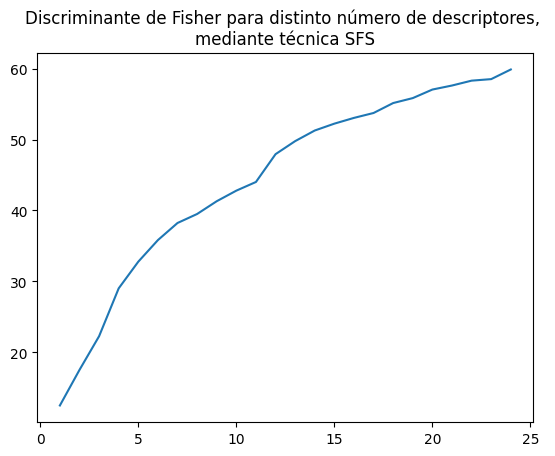

In [6]:
t = [np.array(data_train[colores_features].loc[df_datos["category"] == i]) for i in range(1,11)]

def cb(Tensor, descriptores, num_categorias):
    #debe recibir el Tensor como una lista de matrices y los descriptores como índices
    # Como normalizamos los datos, la media es 0, por lo que solo debo determinar la media de cada descriptor
    dimension_matriz_cuadrada = len(descriptores)
    cb = np.zeros(( dimension_matriz_cuadrada, dimension_matriz_cuadrada))
    for matriz in Tensor:
        sub_matriz = matriz[:,descriptores]
        media_matriz = np.mean(sub_matriz, axis = 0).reshape(-1,1)
        cb+= np.dot(media_matriz,media_matriz.T)/num_categorias # se entiende que 1/num_categorias es la probabilidad
    
    return cb

def cw(Tensor, descriptores, num_categorias):
    dimension_matriz_cuadrada = len(descriptores)
    cw = np.zeros(( dimension_matriz_cuadrada, dimension_matriz_cuadrada))
    #print(cw)
    for matriz in Tensor:
        sub_matriz = matriz[:,descriptores]
        #print(sub_matriz)
        covarianza = np.cov(sub_matriz.T)
        #print(covarianza)
        cw += covarianza/num_categorias
    
    return cw

def J(Tensor, descriptores, num_categorias):
    c_b = cb(Tensor, descriptores, num_categorias)
    c_w = cw(Tensor, descriptores, num_categorias)

    c_w_1 = np.linalg.inv(c_w)
    return np.trace(np.dot(c_w_1, c_b))

num_descriptores = 24

indice_descs = []
j_por_num_descriptores = []
j = 0
#vamos sumando descriptores, hasta que llegemos a los descriptores deseados

while len(indice_descs) < num_descriptores:
    desc = -1
    
    for i in range(len(colores_features)):
        if i in indice_descs:
            continue
        j_c = J(t,indice_descs + [i],10 )
        if j_c > j:
            j = j_c
            desc = i
            
            
    
    #una vez que terminamos, agregamos el mejor descriptor a la lista de descriptores.
    indice_descs.append(desc)
    j_por_num_descriptores.append(j)
    print(f"Discriminante de Fisher para {len(indice_descs)} descriptor{'' if len(indice_descs) == 1 else 'es'}: {round(j,2)}")


#np.array(colores_features)[descs]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
plt.title("Discriminante de Fisher para distinto número de descriptores, \nmediante técnica SFS")
plt.plot([i for i in range(1,25)], j_por_num_descriptores)
plt.show()



5) Vamos a usar 13 descriptores para llegar a un índice de Fisher cercano a 50

In [7]:
indice_descs_trim = indice_descs[0:13]
np.array(colores_features)[indice_descs_trim]

array(['green_contrast', 'green_correlation', 'red_homogeneity',
       'gray_energy', 'blue_contrast', 'blue_correlation',
       'gray_homogeneity', 'green_dissimilarity', 'green_homogeneity',
       'green_ASM', 'red_energy', 'red_correlation', 'red_contrast'],
      dtype='<U19')

6) KNN: Para KNN probaremos distinto número de vecinos, para ver que modelo es el que mejor f1-score (promedio simple). se partirá en 3 y se terminará en 12

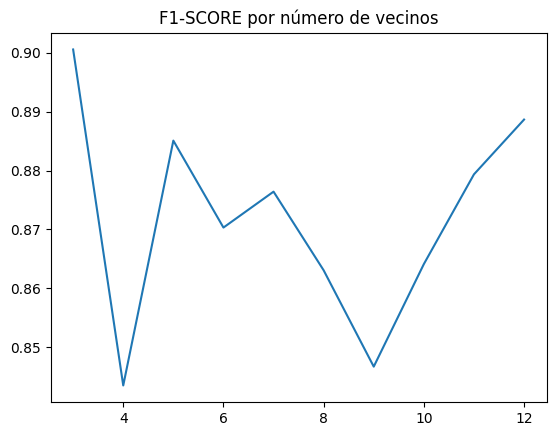

[0.9006, 0.8435, 0.8851, 0.8703, 0.8764, 0.8631, 0.8467, 0.8641, 0.8794, 0.8887]


In [8]:
f1s = []
for i in range(3,13):
    predictorknn = KNeighborsClassifier(n_neighbors=i)
    predictorknn.fit(X_train[np.array(colores_features)[indice_descs_trim]], y_train)
    y_predict = predictorknn.predict(X_test[np.array(colores_features)[indice_descs_trim]])
    f1 = f1_score(y_test, y_predict, average = 'macro')
    f1s.append(f1)

plt.title("F1-SCORE por número de vecinos")
plt.plot(range(3,13),f1s)
plt.show()
print([round(i,4) for i in f1s])
    

Vemos que para 3 y 12 vecinos se obtiene el mejor Accuracy. Trabajaremos con la versión de 5 que es más simple.

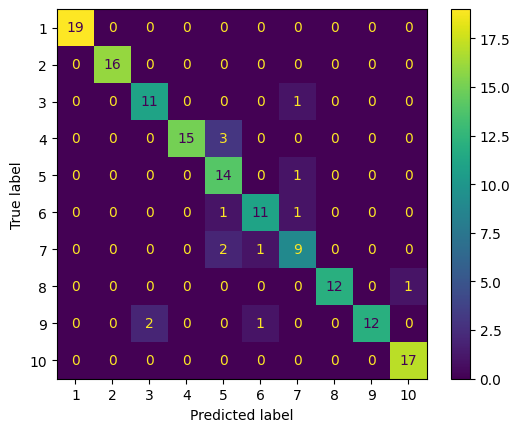

In [9]:
predictorknn = KNeighborsClassifier(n_neighbors=3)
predictorknn.fit(X_train[np.array(colores_features)[indice_descs_trim]], y_train)
y_predict = predictorknn.predict(X_test[np.array(colores_features)[indice_descs_trim]])

confusion = confusion_matrix(y_test, y_predict, labels = list(range(1,11)))
disp = ConfusionMatrixDisplay(confusion_matrix = confusion, display_labels=list(range(1,11)))
disp.plot()
plt.show()

In [10]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        19
         2.0       1.00      1.00      1.00        16
         3.0       0.85      0.92      0.88        12
         4.0       1.00      0.83      0.91        18
         5.0       0.70      0.93      0.80        15
         6.0       0.85      0.85      0.85        13
         7.0       0.75      0.75      0.75        12
         8.0       1.00      0.92      0.96        13
         9.0       1.00      0.80      0.89        15
        10.0       0.94      1.00      0.97        17

    accuracy                           0.91       150
   macro avg       0.91      0.90      0.90       150
weighted avg       0.92      0.91      0.91       150



En general vemos que es un buen clasificador, presentando problemas principalmente en la clase 7

7) Vamos a probar los mismos parámetros, utilizando un GaussianNB

In [11]:
modelo = GaussianNB()

modelo.fit(data_train[np.array(colores_features)[indice_descs_trim]], y_train)

y_predict = modelo.predict(X_test[np.array(colores_features)[indice_descs_trim]])
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        19
         2.0       1.00      1.00      1.00        16
         3.0       0.59      0.83      0.69        12
         4.0       0.82      0.78      0.80        18
         5.0       0.62      1.00      0.77        15
         6.0       0.55      0.46      0.50        13
         7.0       0.67      0.33      0.44        12
         8.0       1.00      0.92      0.96        13
         9.0       0.91      0.67      0.77        15
        10.0       0.94      0.94      0.94        17

    accuracy                           0.81       150
   macro avg       0.81      0.79      0.79       150
weighted avg       0.83      0.81      0.81       150



Si bien el F1-Score no baja tanto, la clase 7 por ejemplo es pesimamente clasificada, el Recall es de sólo un 33%, lo que significa que solo un 33% de los elementos de la clase 7 fueron clasificados como tal. Por tanto no considero que en este estado sea un buen clasificador. Pero intentaré la siguiente transformación.

Naive Bayes asume que los parámetros son independientes ( correlación 0) lo que no es el caso, viendo la matriz de covarianzas.

In [12]:
covarianzas = np.cov(X_train[np.array(colores_features)[indice_descs_trim]].T)
np.round(covarianzas, 2)

array([[ 1.  , -0.57, -0.9 , -0.77,  0.98, -0.59, -0.94,  0.99, -0.95,
        -0.7 , -0.72, -0.58,  0.98],
       [-0.57,  1.  ,  0.57,  0.19, -0.65,  0.99,  0.62, -0.6 ,  0.62,
         0.14,  0.18,  0.95, -0.58],
       [-0.9 ,  0.57,  1.  ,  0.87, -0.91,  0.59,  0.99, -0.95,  0.98,
         0.81,  0.88,  0.63, -0.96],
       [-0.77,  0.19,  0.87,  1.  , -0.75,  0.22,  0.86, -0.82,  0.86,
         0.99,  0.96,  0.26, -0.8 ],
       [ 0.98, -0.65, -0.91, -0.75,  1.  , -0.67, -0.95,  0.98, -0.95,
        -0.68, -0.71, -0.66,  0.97],
       [-0.59,  0.99,  0.59,  0.22, -0.67,  1.  ,  0.64, -0.62,  0.64,
         0.17,  0.2 ,  0.94, -0.6 ],
       [-0.94,  0.62,  0.99,  0.86, -0.95,  0.64,  1.  , -0.98,  1.  ,
         0.8 ,  0.84,  0.66, -0.97],
       [ 0.99, -0.6 , -0.95, -0.82,  0.98, -0.62, -0.98,  1.  , -0.98,
        -0.76, -0.78, -0.62,  0.99],
       [-0.95,  0.62,  0.98,  0.86, -0.95,  0.64,  1.  , -0.98,  1.  ,
         0.81,  0.84,  0.65, -0.97],
       [-0.7 ,  0.14,  0.81,

Vemos que el resultado está lejos de una matriz diagonal, por lo que pasaremos los datos por un proceso PCA donde los nuevos descriptores están menos correlacionados ( por lo menos del punto de vista de la covarianza de Pearson). 

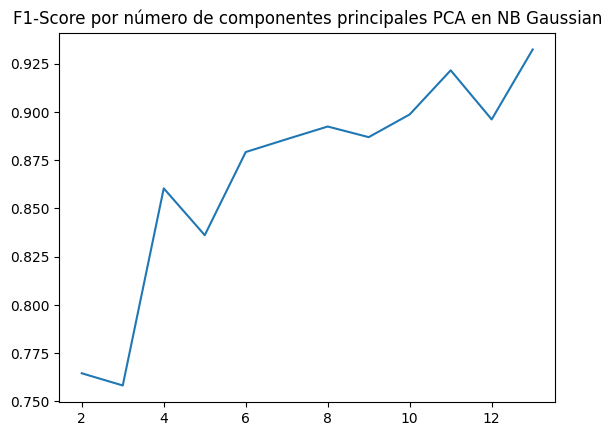

[0.7645, 0.7582, 0.8604, 0.8361, 0.8793, 0.8859, 0.8925, 0.887, 0.8988, 0.9216, 0.8962, 0.9324]


In [13]:
values, Vectors = np.linalg.eig(covarianzas)

f1s = []

for num_vec_principal in range(2,14):

    x_pca_train = np.dot(X_train[np.array(colores_features)[indice_descs_trim]],Vectors[:,0:num_vec_principal])
    x_pca_test = np.dot(X_test[np.array(colores_features)[indice_descs_trim]],Vectors[:,0:num_vec_principal])

# x_pca_train = np.dot(datos_para_pca,V[:,0:13])
# #x_pca_test = np.dot(np.array(data_test[np.array(colores_features)[descs]]),V)
# x_pca_test = np.dot(np.array(data_test),V[:,0:13])

    modelo = GaussianNB()

    modelo.fit(x_pca_train, y_train)
    y_predict = modelo.predict(x_pca_test)

    f1 = f1_score(y_test, y_predict, average = 'macro')
    f1s.append(f1)

plt.title("F1-Score por número de componentes principales PCA en NB Gaussian")
plt.plot(range(2,len(f1s)+2),f1s)
plt.show()
print([round(i,4) for i in f1s])
#print(classification_report(y_test, y_predict))


Vemos en este caso, que utilizando todas las componentes principales ( para 13 descriptores), se obtiene un Accuracy de 0,94, lo cual es muy bueno ya que solo se hicieron transformaciones lineales sobre los descriptores.

In [14]:
x_pca_train = np.dot(X_train[np.array(colores_features)[indice_descs_trim]],Vectors[:,0:num_vec_principal])
x_pca_test = np.dot(X_test[np.array(colores_features)[indice_descs_trim]],Vectors[:,0:num_vec_principal])

# x_pca_train = np.dot(datos_para_pca,V[:,0:13])
# #x_pca_test = np.dot(np.array(data_test[np.array(colores_features)[descs]]),V)
# x_pca_test = np.dot(np.array(data_test),V[:,0:13])

modelo = GaussianNB()

modelo.fit(x_pca_train, y_train)
y_predict = modelo.predict(x_pca_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        19
         2.0       1.00      1.00      1.00        16
         3.0       0.92      1.00      0.96        12
         4.0       0.94      0.94      0.94        18
         5.0       0.70      0.93      0.80        15
         6.0       1.00      0.92      0.96        13
         7.0       0.88      0.58      0.70        12
         8.0       1.00      0.92      0.96        13
         9.0       1.00      1.00      1.00        15
        10.0       1.00      1.00      1.00        17

    accuracy                           0.94       150
   macro avg       0.94      0.93      0.93       150
weighted avg       0.95      0.94      0.94       150



En este caso, vemos como todas las clasificaciones mejoraron cosiderablemente. Solo las clases 5 y 7 podrían presentar mayores problemas, siendo el F1-score de la clase 5 similar al F1-score de la clase 5 con KNN y solo la clase 7 estaría siendo peor evaluada. Todas las otras clases tienen un rendimiento excelente.

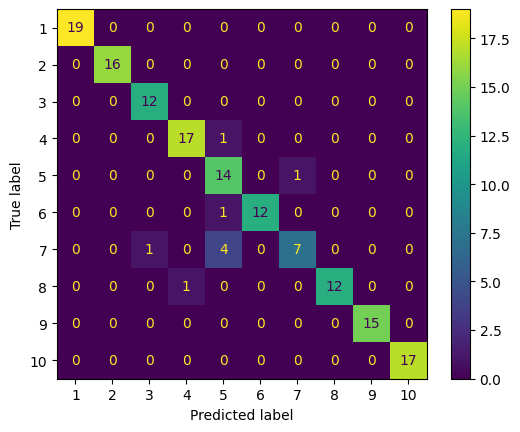

In [15]:
confusion = confusion_matrix(y_test, y_predict, labels = list(range(1,11)))
disp = ConfusionMatrixDisplay(confusion_matrix = confusion, display_labels=list(range(1,11)))
disp.plot()
plt.show()

8) Estudiaremos como funciona el árbol de decisión. Probaremos el F1-Score con distintos criterios

In [16]:
criterions = ["gini", "entropy", "log_loss"]
for crt in criterions:
    clf = DecisionTreeClassifier(random_state=0, criterion = crt)
    clf.fit(data_train[np.array(colores_features)[indice_descs_trim]], y_train)
    y_predict = clf.predict(data_test[np.array(colores_features)[indice_descs_trim]])
    f1 = f1_score(y_test, y_predict, average = 'macro')
    
    print(f"F1-Score criterio {crt}: {round(f1,2)}")

F1-Score criterio gini: 0.91
F1-Score criterio entropy: 0.88
F1-Score criterio log_loss: 0.88


Podemos ver que en este caso el mejor criterio es gini, por lo que veremos más detalladamente como se ve las predicciones de cada una de las clases

In [17]:
clf = DecisionTreeClassifier(random_state=0, criterion = "gini")
clf.fit(data_train[np.array(colores_features)[indice_descs_trim]], y_train)
y_predict = clf.predict(data_test[np.array(colores_features)[indice_descs_trim]])
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        19
         2.0       1.00      1.00      1.00        16
         3.0       0.85      0.92      0.88        12
         4.0       0.88      0.78      0.82        18
         5.0       0.87      0.87      0.87        15
         6.0       1.00      0.85      0.92        13
         7.0       0.65      0.92      0.76        12
         8.0       1.00      0.92      0.96        13
         9.0       0.93      0.93      0.93        15
        10.0       1.00      0.94      0.97        17

    accuracy                           0.91       150
   macro avg       0.92      0.91      0.91       150
weighted avg       0.92      0.91      0.92       150



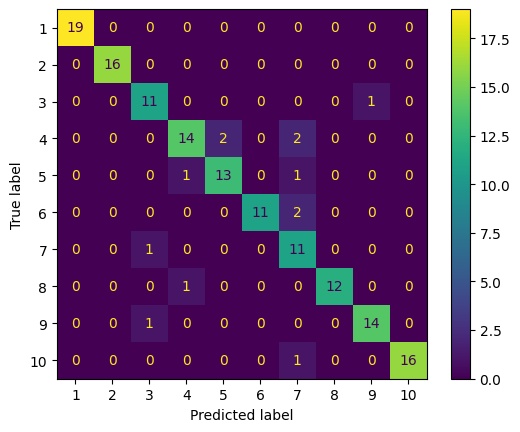

In [18]:
confusion = confusion_matrix(y_test, y_predict, labels = list(range(1,11)))
disp = ConfusionMatrixDisplay(confusion_matrix = confusion, display_labels=list(range(1,11)))
disp.plot()
plt.show()

En este caso, vemos que la métrica F1 es levemente inferior al caso de GNB, pero en particular mejoran las clases 5 y 7, aunque empeora la clase 4. En base a esto, dado que los 3 estimadores tienen rendimientos similares, considero que la opción a elegir debiese ser el modelo KNN, que es el que parece ser más estable en cuanto a calidad de predicción.



9) Para seguir con el análisis, dados los hiperparámetros seleccionados, veremos como cambia el F1- Score cambiando el número de descriptores, utilizando el orden establecido al inicio de este trabajo mediante SFS.

In [19]:
f1s = []
for indice in range(0,len(indice_descs)):
    predictorknn = KNeighborsClassifier(n_neighbors=3)
    predictorknn.fit(X_train[np.array(colores_features)[indice_descs[0:indice+1]]], y_train)
    y_predict = predictorknn.predict(X_test[np.array(colores_features)[indice_descs[0:indice+1]]])
    f1 = f1_score(y_test, y_predict, average = 'macro')
    print(f"Número de descriptores: {indice+1}, F1-Score: {round(f1,4)}")
    f1s.append(f1)
    


Número de descriptores: 1, F1-Score: 0.3496
Número de descriptores: 2, F1-Score: 0.7261
Número de descriptores: 3, F1-Score: 0.8478
Número de descriptores: 4, F1-Score: 0.9019
Número de descriptores: 5, F1-Score: 0.9079
Número de descriptores: 6, F1-Score: 0.8798
Número de descriptores: 7, F1-Score: 0.8649
Número de descriptores: 8, F1-Score: 0.8635
Número de descriptores: 9, F1-Score: 0.8802
Número de descriptores: 10, F1-Score: 0.9146
Número de descriptores: 11, F1-Score: 0.8791
Número de descriptores: 12, F1-Score: 0.874
Número de descriptores: 13, F1-Score: 0.9006
Número de descriptores: 14, F1-Score: 0.885
Número de descriptores: 15, F1-Score: 0.9009
Número de descriptores: 16, F1-Score: 0.8913
Número de descriptores: 17, F1-Score: 0.8993
Número de descriptores: 18, F1-Score: 0.8985
Número de descriptores: 19, F1-Score: 0.8993
Número de descriptores: 20, F1-Score: 0.8927
Número de descriptores: 21, F1-Score: 0.8859
Número de descriptores: 22, F1-Score: 0.8993
Número de descriptore

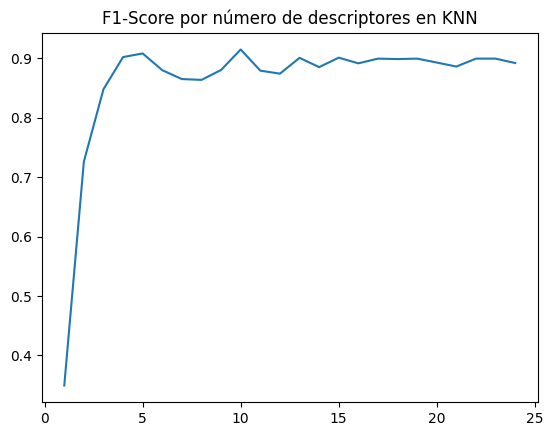

In [20]:
plt.title("F1-Score por número de descriptores en KNN")
plt.plot(range(1,len(f1s)+1),f1s)
plt.show()

Ahora probaremos con NB, en este caso partiremos desde 2 descriptores para poder aplicar PCA corectamente

In [21]:
f1s = []
for indice in range(1,len(indice_descs)):
    covarianzas = np.cov(X_train[np.array(colores_features)[indice_descs[0:indice+1]]].T)
    values, Vectors = np.linalg.eig(covarianzas)
    x_pca_train = np.dot(X_train[np.array(colores_features)[indice_descs[0:indice+1]]],Vectors)
    x_pca_test = np.dot(X_test[np.array(colores_features)[indice_descs[0:indice+1]]],Vectors)
    
    modelo = GaussianNB()

    modelo.fit(x_pca_train, y_train)
    y_predict = modelo.predict(x_pca_test)

    
    # print(indice_descs[0:indice+1])
    # predictorknn = KNeighborsClassifier(n_neighbors=3)
    # predictorknn.fit(X_train[np.array(colores_features)[indice_descs[0:indice+1]]], y_train)
    # y_predict = predictorknn.predict(X_test[np.array(colores_features)[indice_descs[0:indice+1]]])
    f1 = f1_score(y_test, y_predict, average = 'macro')
    print(f"Número de descriptores: {indice+1}, F1-Score: {round(f1,4)}")
    f1s.append(f1)

Número de descriptores: 2, F1-Score: 0.7689
Número de descriptores: 3, F1-Score: 0.8253
Número de descriptores: 4, F1-Score: 0.8708
Número de descriptores: 5, F1-Score: 0.8756
Número de descriptores: 6, F1-Score: 0.8832
Número de descriptores: 7, F1-Score: 0.8833
Número de descriptores: 8, F1-Score: 0.8889
Número de descriptores: 9, F1-Score: 0.907
Número de descriptores: 10, F1-Score: 0.9084
Número de descriptores: 11, F1-Score: 0.9125
Número de descriptores: 12, F1-Score: 0.904
Número de descriptores: 13, F1-Score: 0.9324
Número de descriptores: 14, F1-Score: 0.9324
Número de descriptores: 15, F1-Score: 0.9377
Número de descriptores: 16, F1-Score: 0.9138
Número de descriptores: 17, F1-Score: 0.926
Número de descriptores: 18, F1-Score: 0.8969
Número de descriptores: 19, F1-Score: 0.9057
Número de descriptores: 20, F1-Score: 0.8872
Número de descriptores: 21, F1-Score: 0.8934
Número de descriptores: 22, F1-Score: 0.882
Número de descriptores: 23, F1-Score: 0.8874
Número de descriptores

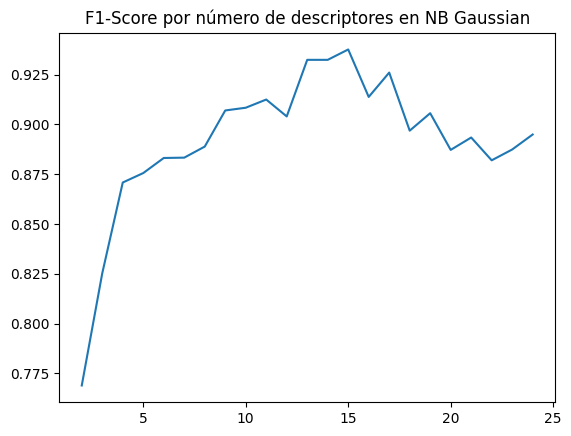

In [22]:
plt.title("F1-Score por número de descriptores en NB Gaussian")
plt.plot(range(2,len(f1s)+2),f1s)
plt.show()

In [23]:
f1s = []
for indice in range(1,len(indice_descs)):
    clf = DecisionTreeClassifier(random_state=0, criterion = "gini")
    clf.fit(data_train[np.array(colores_features)[indice_descs[0:indice+1]]], y_train)
    y_predict = clf.predict(data_test[np.array(colores_features)[indice_descs[0:indice+1]]])
    f1 = f1_score(y_test, y_predict, average = 'macro')
    print(f"Número de descriptores: {indice+1}, F1-Score: {round(f1,4)}")
    f1s.append(f1)

Número de descriptores: 2, F1-Score: 0.6956
Número de descriptores: 3, F1-Score: 0.8009
Número de descriptores: 4, F1-Score: 0.8493
Número de descriptores: 5, F1-Score: 0.8269
Número de descriptores: 6, F1-Score: 0.8282
Número de descriptores: 7, F1-Score: 0.8492
Número de descriptores: 8, F1-Score: 0.8849
Número de descriptores: 9, F1-Score: 0.9057
Número de descriptores: 10, F1-Score: 0.8688
Número de descriptores: 11, F1-Score: 0.8687
Número de descriptores: 12, F1-Score: 0.8599
Número de descriptores: 13, F1-Score: 0.9109
Número de descriptores: 14, F1-Score: 0.9
Número de descriptores: 15, F1-Score: 0.8874
Número de descriptores: 16, F1-Score: 0.8613
Número de descriptores: 17, F1-Score: 0.8326
Número de descriptores: 18, F1-Score: 0.8681
Número de descriptores: 19, F1-Score: 0.8623
Número de descriptores: 20, F1-Score: 0.8598
Número de descriptores: 21, F1-Score: 0.8808
Número de descriptores: 22, F1-Score: 0.8545
Número de descriptores: 23, F1-Score: 0.8719
Número de descriptore

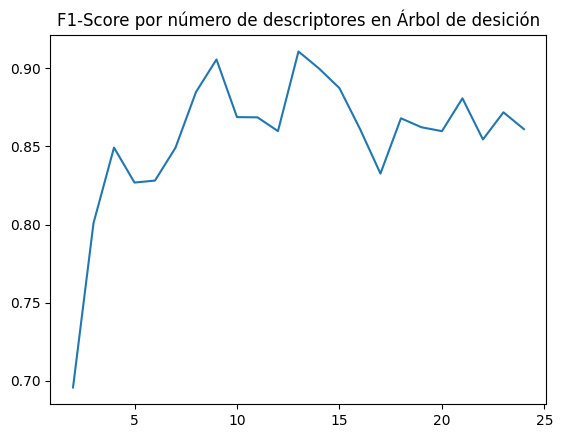

In [24]:
plt.title("F1-Score por número de descriptores en Árbol de desición")
plt.plot(range(2,len(f1s)+2),f1s)
plt.show()

Nuevamente podemos observar que el predicto KNN tuvo una mejor respuesta ante cambios en los número de descriptores, pasado cierto umbral, a diferencia del clasificador NB y DT, que si bien tuvieron puntajes altos, era más pronunciada la oscilación al cambiar el número de descriptores. Por tal motivo, considero que el descriptor adecuado para este caso, debiese ser KNN.